#### ALL FLOW

In [1]:
import os
import shutil
def copy_all_from_runs_to_src():
    # get current directory
    cwd = os.getcwd()
    parent = os.path.dirname(cwd)
    parent = os.path.dirname(parent)
    src_folder = parent + '\\Generation\\runs\\' 
    dst_folder = './src/'
    for file_name in os.listdir(src_folder):
        shutil.copy(src_folder + file_name, dst_folder)
    print(f'Copied all files from {src_folder} to {dst_folder}')

def convert_to_pre_eval(exp_name):
    sf = f'src/{exp_name}.jsonl'
    td = f'tgt/{exp_name.replace("-", "")}'
    !python convert_to_pre_eval.py --source_file $sf --target_dir $td
    print(f'Converted {sf} to {td}')

def run_evaluation(exp_name):
    sf = f'src/{exp_name}.jsonl'
    td = f'tgt/{exp_name.replace("-", "")}'
    eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"
    print(f'The evaluation command is: \n{eval_cmd}\n Copy it and run it in the terminal')

def run_pass_k(exp_name):
    target_dir = f'tgt/{exp_name.replace("-", "")}'
    output_file = f'res/{exp_name}_results.json'
    !python pass_k.py $target_dir --output $output_file
    print(f'Pass@k results saved to {output_file}')


In [4]:
copy_all_from_runs_to_src()

# my_folder = './src/'
# for file_name in os.listdir(my_folder):
#     exp_name = file_name.split('.jsonl')[0]
#     if exp_name.endswith('_pass_at_10_gen_config'):
#         print(f'Now running experiment: {exp_name}')
#     if exp_name.endswith('_pass_at_100_gen_config'):
#         print(f'Now running experiment: {exp_name}')
exp_names = [
    # 'codegen_java_LoRa_v7_run_1_checkpoint_4000_humaneval_py_pass_at_10_gen_config',
    # 'codegen_java_LoRa_v7_run_1_checkpoint_4000_humaneval_java_pass_at_10_gen_config',
    # 'codegen_java_LoRa_v7_run_1_checkpoint_4000_humaneval_rs_pass_at_10_gen_config',

    'codegen_350M_multi_humaneval_rs_pass_at_10_gen_config',
    'codegen_350M_multi_humaneval_py_pass_at_10_gen_config',
    'codegen_350M_multi_humaneval_java_pass_at_10_gen_config',

    # 'codegen_rust_v7_run_1_checkpoint_2000_humaneval_rs_pass_at_10_gen_config',
    # 'codegen_rust_v7_run_1_checkpoint_2000_humaneval_py_pass_at_10_gen_config',
    # 'codegen_rust_v7_run_1_checkpoint_2000_humaneval_java_pass_at_10_gen_config',
]

Copied all files from c:\Users\Edin\OneDrive - University of Edinburgh\Study\Sem3\Project\LLM-for-code-intelligence\Generation\runs\ to ./src/


In [5]:
def run_all(exp_name):
    print(f'{"="*20} Now running experiment: {exp_name} {"="*20}')
    convert_to_pre_eval(exp_name)
    run_evaluation(exp_name)
    # run_pass_k(exp_name)
    # print(f'{"="*20} Finished experiment: {exp_name} {"="*20}')
for exp_name in exp_names:
    # print(f'Now running experiment: {exp_name}')
    run_all(exp_name)



==================== Now running experiment: codegen_350M_multi_humaneval_rs_pass_at_10_gen_config ====================
Done.
Converted src/codegen_350M_multi_humaneval_rs_pass_at_10_gen_config.jsonl to tgt/codegen_350M_multi_humaneval_rs_pass_at_10_gen_config
The evaluation command is: 
podman run --rm --network none -v ./tgt/codegen_350M_multi_humaneval_rs_pass_at_10_gen_config:/tgt/codegen_350M_multi_humaneval_rs_pass_at_10_gen_config:rw multipl-e-eval --dir /tgt/codegen_350M_multi_humaneval_rs_pass_at_10_gen_config --output-dir /tgt/codegen_350M_multi_humaneval_rs_pass_at_10_gen_config --recursive
 Copy it and run it in the terminal
==================== Now running experiment: codegen_350M_multi_humaneval_py_pass_at_10_gen_config ====================



100%|██████████| 1560/1560 [00:00<00:00, 781174.10jsonline/s]


Done.
Converted src/codegen_350M_multi_humaneval_py_pass_at_10_gen_config.jsonl to tgt/codegen_350M_multi_humaneval_py_pass_at_10_gen_config
The evaluation command is: 
podman run --rm --network none -v ./tgt/codegen_350M_multi_humaneval_py_pass_at_10_gen_config:/tgt/codegen_350M_multi_humaneval_py_pass_at_10_gen_config:rw multipl-e-eval --dir /tgt/codegen_350M_multi_humaneval_py_pass_at_10_gen_config --output-dir /tgt/codegen_350M_multi_humaneval_py_pass_at_10_gen_config --recursive
 Copy it and run it in the terminal
==================== Now running experiment: codegen_350M_multi_humaneval_java_pass_at_10_gen_config ====================



100%|██████████| 1610/1610 [00:00<00:00, 1004586.35jsonline/s]


Done.
Converted src/codegen_350M_multi_humaneval_java_pass_at_10_gen_config.jsonl to tgt/codegen_350M_multi_humaneval_java_pass_at_10_gen_config
The evaluation command is: 
podman run --rm --network none -v ./tgt/codegen_350M_multi_humaneval_java_pass_at_10_gen_config:/tgt/codegen_350M_multi_humaneval_java_pass_at_10_gen_config:rw multipl-e-eval --dir /tgt/codegen_350M_multi_humaneval_java_pass_at_10_gen_config --output-dir /tgt/codegen_350M_multi_humaneval_java_pass_at_10_gen_config --recursive
 Copy it and run it in the terminal



100%|██████████| 1580/1580 [00:00<00:00, 559429.37jsonline/s]


#### Visualize the results

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


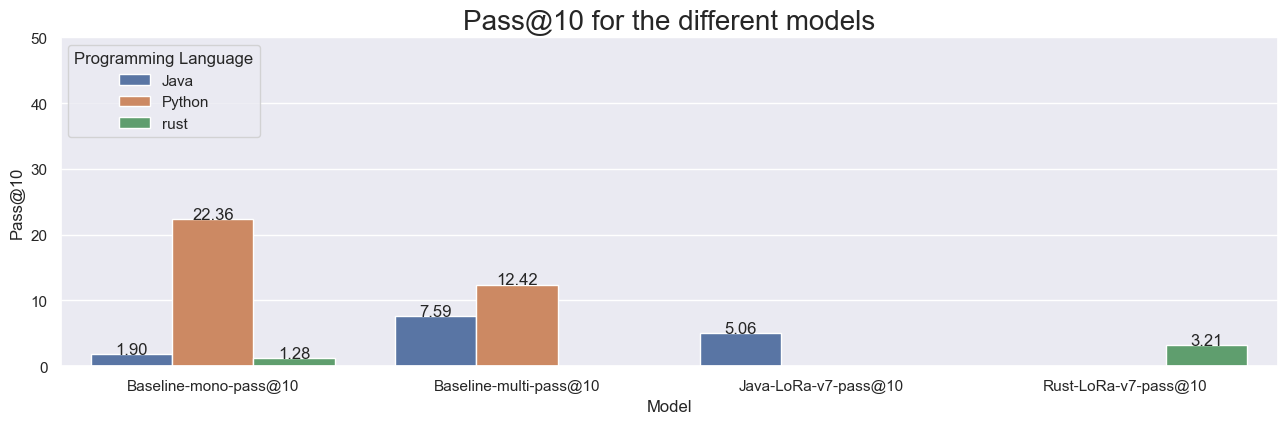

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

#get all the results files in the res folder
results_files = [f for f in os.listdir('res') if os.path.isfile(os.path.join('res', f))]

#load all the results files into a dictionary
results = {}
for f in results_files:
    with open(os.path.join('res', f)) as json_file:
        results[f] = json.load(json_file)
model_names_dict = {
    
    'codegen_350M_mono_humaneval_py_pass_at_10_gen_config': 'Baseline-mono-pass@10',
    'codegen_350M_mono_humaneval_java_pass_at_10_gen_config': 'Baseline-mono-pass@10',
    'codegen_350M_mono_humaneval_rs_pass_at_10_gen_config': 'Baseline-mono-pass@10',

    'codegen_350M_multi_humaneval_py_pass_at_10_gen_config': 'Baseline-multi-pass@10',
    'codegen_350M_multi_humaneval_java_pass_at_10_gen_config': 'Baseline-multi-pass@10',
    'codegen_350M_multi_humaneval_rs_pass_at_10_gen_config': 'Baseline-multi-pass@10',

    'codegen_java_LoRa_v7_run_1_checkpoint_4000_humaneval_java_pass_at_10_gen_config': 'Java-LoRa-v7-pass@10',
    'codegen_java_LoRa_v7_run_1_checkpoint_4000_humaneval_py_pass_at_10_gen_config': 'Java-LoRa-v7-pass@10',
    'codegen_java_LoRa_v7_run_1_checkpoint_4000_humaneval_rs_pass_at_10_gen_config': 'Java-LoRa-v7-pass@10',

    'codegen_rust_v7_run_1_checkpoint_2000_humaneval_rs_pass_at_10_gen_config': 'Rust-LoRa-v7-pass@10',
    'codegen_rust_v7_run_1_checkpoint_2000_humaneval_py_pass_at_10_gen_config': 'Rust-LoRa-v7-pass@10',
    'codegen_rust_v7_run_1_checkpoint_2000_humaneval_java_pass_at_10_gen_config': 'Rust-LoRa-v7-pass@10',
    

}


#Merge all the results into a single dataframe
dict_df = { 'model': [], 'dataset': [], 'pass@10': [], 'pass@100': [], 'num_problems': [], 'min_completions': [], 'max_completions': [], 'programming_language': []}

for model in results.keys():
    model_results = results[model]
    model_name = model.split('_results.json')[0]
    if model_name in model_names_dict.keys():
        model_name = model_names_dict[model_name]
    else:
        # print('Model name not found in dict: ' + model_name)
        continue
    dataset_name = model_results['pass@10']['dataset']
    pass_10 = model_results['pass@10']['estimate']
    pass_100 = model_results['pass@100']['estimate']
    num_problems = model_results['pass@10']['num_problems']
    min_completions = model_results['pass@10']['min_completions']
    max_completions = model_results['pass@10']['max_completions']
    if 'humaneval_py' in dataset_name:
        programming_language = 'python'
    elif 'humaneval_java' in dataset_name:
        programming_language = 'java'
    elif 'humaneval_rs' in dataset_name:
        programming_language = 'rust'
    else:
        programming_language = 'unknown'
    dict_df['model'].append(model_name)
    dict_df['dataset'].append(dataset_name)
    dict_df['pass@10'].append(pass_10)
    dict_df['pass@100'].append(pass_100)
    dict_df['num_problems'].append(num_problems)
    dict_df['min_completions'].append(min_completions)
    dict_df['max_completions'].append(max_completions)
    dict_df['programming_language'].append(programming_language)

df = pd.DataFrame(dict_df)
df = df.drop(columns=['dataset'])
df = df.drop(columns=['min_completions', 'max_completions'])
df = df[df['model'] != 'LoRa-V3-2000']
df = df[df['model'] != 'LoRa-V5-1000']
df['pass@10'] = df['pass@10'] * 100
df['pass@100'] = df['pass@100'] * 100

df = df.rename(columns={'programming_language': 'Programming Language'})
df = df.rename(columns={'model': 'Model'})
df = df.rename(columns={'pass@10': 'Pass@10'})
df = df.rename(columns={'pass@100': 'Pass@100'})

df['Programming Language'] = df['Programming Language'].replace({'java': 'Java', 'python': 'Python'})

#Sort the dataframe by the model name
df = df.sort_values(by=['Model'])

#Set the pass type to plot
pass_type = 'Pass@10'


#Plot the results
#Set the style
sns.set_theme(style="whitegrid")
#Set the plot size
sns.set(rc={'figure.figsize':(15.7,4.27)})
ax = sns.barplot(x="Model", y=pass_type, hue="Programming Language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 50
plt.ylim(0, 50)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#Add a title in bigger font
plt.title(f'{pass_type} for the different models', fontsize=20)
plt.show()



In [3]:
# df where programming language is Python
df_python = df[df['Programming Language'] == 'Python']

# df where programming language is Java
df_java = df[df['Programming Language'] == 'Java']

# df_python
# df_java
df

,Model,Pass@10,Pass@100,num_problems,Programming Language
0,Baseline-mono-pass@10,1.898734,100.0,158,Java
1,Baseline-mono-pass@10,22.360248,100.0,161,Python
2,Baseline-mono-pass@10,1.282051,100.0,156,rust
3,Baseline-multi-pass@10,7.594937,100.0,158,Java
4,Baseline-multi-pass@10,12.422360,100.0,161,Python
5,Java-LoRa-v7-pass@10,5.063291,100.0,158,Java
6,Rust-LoRa-v7-pass@10,3.205128,100.0,156,rust
